In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2
%load_ext line_profiler

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # adapt plots for retina displays
from IPython.core.debugger import set_trace

import utils

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [3]:
from tqdm import tqdm_notebook
import collections
import os

# Datasets and Preprocessing

## FB15K-237

In [7]:
%%bash

# Download and unzip FB15K-237.
#cd ../data
#mkdir fb15k-237
#cd fb15k-237
#wget https://download.microsoft.com/download/8/7/0/8700516A-AB3D-4850-B4BB-805C515AECE1/FB15K-237.2.zip
#unzip FB15K-237.2.zip

In [6]:
fb_dir = '../data/fb15k-237/Release'

In [7]:
train_triples = pd.read_csv(os.path.join(fb_dir, 'train.txt'), sep='\t', names=['subject', 'relation', 'object'])
val_triples = pd.read_csv(os.path.join(fb_dir, 'valid.txt'), sep='\t', names=['subject', 'relation', 'object'])
test_triples = pd.read_csv(os.path.join(fb_dir, 'test.txt'), sep='\t', names=['subject', 'relation', 'object'])
print(len(train_triples), len(val_triples), len(test_triples))
train_triples.head()

272115 17535 20466


,subject,relation,object
0,/m/027rn,/location/country/form_of_government,/m/06cx9
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0
2,/m/07s9rl0,/media_common/netflix_genre/titles,/m/0170z3
3,/m/01sl1q,/award/award_winner/awards_won./award/award_ho...,/m/044mz_
4,/m/0cnk2q,/soccer/football_team/current_roster./sports/s...,/m/02nzb8


In [8]:
entity_map = utils.IndexMap(train_triples[['subject', 'object']], 
                            val_triples[['subject', 'object']], 
                            test_triples[['subject', 'object']])

num_nodes = len(entity_map)
num_nodes

14541

In [9]:
feat_data = np.eye(num_nodes)

In [10]:
# For non-relational model.
adj_lists = collections.defaultdict(set)
for i, row in tqdm_notebook(train_triples.iterrows(), total=len(train_triples)):
    subject_index = entity_map.to_index(row['subject'])
    object_index = entity_map.to_index(row['object'])
    # Use non-directed edges here.
    adj_lists[subject_index].add(object_index)
    adj_lists[object_index].add(subject_index)

HBox(children=(IntProgress(value=0, max=272115), HTML(value=u'')))

In [10]:
# For relational model.
relation_map = utils.IndexMap(train_triples['relation'], 
                              val_triples['relation'], 
                              test_triples['relation'])
num_relations = len(relation_map)
print(num_relations)

# TODO: Implement train test split before doing this, otherwise the network indirectly sees the true connections.
adj_lists_per_relation = collections.defaultdict(lambda: collections.defaultdict(set))
for i, row in tqdm_notebook(train_triples.iterrows(), total=len(train_triples)):
    subject_index = entity_map.to_index(row['subject'])
    object_index = entity_map.to_index(row['object'])
    relation_index = relation_map.to_index(row['relation'])
    
    adj_lists_per_relation[relation_index][subject_index].add(object_index)
    #adj_lists_per_relation[rating_index][item_index].add(user_index)  # undirected edges

237


HBox(children=(IntProgress(value=0, max=272115), HTML(value=u'')))

In [11]:
# For link prediction.
from_nodes = train_triples['subject'].map(entity_map.to_index)
to_nodes = train_triples['object'].map(entity_map.to_index)
relations = train_triples['relation'].map(relation_map.to_index)

triples_arr = np.vstack([from_nodes, to_nodes, relations]).T
len(triples_arr), triples_arr

(272115, array([[ 3818,  8942,   122],
        [  819,  9234,   230],
        [ 9791,   756,   140],
        ...,
        [11737,  4042,   198],
        [12535,  9678,    13],
        [ 3203, 10433,    11]]))

## FB15K-237: Numbers (Garcia-Duran et al. 2017)

In [49]:
%%bash

# Download numerical data from Garcia-Duran et al. (2017).
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/nle-ml/mmkb/master/numTriples_FB15k.txt

In [47]:
numerical_features = pd.read_csv('data/fb15k-237/numTriples_FB15k.txt', sep='\t', names=['entity', 'attribute', 'value'])
numerical_features.head()

,entity,attribute,value
0,/m/06rf7,<http://rdf.freebase.com/ns/location.geocode.l...,9.704049e+00
1,/m/06rf7,<http://rdf.freebase.com/ns/location.geocode.l...,5.420868e+01
2,/m/06rf7,<http://rdf.freebase.com/ns/topic_server.popul...,2.837021e+06
3,/m/06rf7,<http://rdf.freebase.com/ns/location.location....,1.576318e+04
4,/m/04258w,<http://rdf.freebase.com/ns/people.person.date...,1.912667e+03


In [46]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with numerical features:', len(numerical_features['entity'].unique()))
print('Intersection (entities in train set with numerical features):', len(np.intersect1d(numerical_features['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with numerical features: 12493
Intersection (entities in train set with numerical features): 12047


## FB15K-237: Numbers and texts (Kristiadi et al. 2018)

In [52]:
%%bash
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/numerical_literals.txt

--2018-03-05 14:44:55--  https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/numerical_literals.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5196154 (5.0M) [text/plain]
Saving to: 'numerical_literals.txt'

     0K .......... .......... .......... .......... ..........  0% 3.99M 1s
    50K .......... .......... .......... .......... ..........  1% 7.02M 1s
   100K .......... .......... .......... .......... ..........  2% 6.95M 1s
   150K .......... .......... .......... .......... ..........  3% 7.05M 1s
   200K .......... .......... .......... .......... ..........  4% 7.89M 1s
   250K .......... .......... .......... .......... ..........  5% 8.27M 1s
   300K .......... .......... .......... .......... ..........  6% 10.7M 1s
   350K .......... ....

In [53]:
numerical_features_kristiadi = pd.read_csv('data/fb15k-237/numerical_literals.txt', sep='\t', names=['entity', 'attribute', 'value'])
numerical_features_kristiadi.head()

,entity,attribute,value
0,/m/0265wl,http://rdf.freebase.com/ns/award.award_categor...,1965
1,/m/0n5c9,http://rdf.freebase.com/ns/location.location.area,1245.78428107
2,/m/0n5c9,http://rdf.freebase.com/ns/location.dated_loca...,1739
3,/m/0n5c9,http://rdf.freebase.com/ns/topic_server.popula...,462263
4,/m/0n5c9,http://rdf.freebase.com/ns/topic_server.popula...,482155


In [54]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with numerical features:', len(numerical_features_kristiadi['entity'].unique()))
print('Intersection (entities in train set with numerical features):', len(np.intersect1d(numerical_features_kristiadi['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with numerical features: 9941
Intersection (entities in train set with numerical features): 9608


In [55]:
%%bash
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/text_literals.txt

--2018-03-05 14:46:55--  https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/text_literals.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12991982 (12M) [text/plain]
Saving to: 'text_literals.txt'

     0K .......... .......... .......... .......... ..........  0% 1.24M 10s
    50K .......... .......... .......... .......... ..........  0% 4.23M 6s
   100K .......... .......... .......... .......... ..........  1% 6.51M 5s
   150K .......... .......... .......... .......... ..........  1% 6.65M 4s
   200K .......... .......... .......... .......... ..........  1% 7.22M 4s
   250K .......... .......... .......... .......... ..........  2% 10.1M 3s
   300K .......... .......... .......... .......... ..........  2% 8.66M 3s
   350K .......... .......... ..

In [56]:
text_features_kristiadi = pd.read_csv('data/fb15k-237/text_literals.txt', sep='\t', names=['entity', 'attribute', 'value'])
text_features_kristiadi.head()

,entity,attribute,value
0,/m/03j9ml,http://rdf.freebase.com/ns/common.topic.descri...,Maggie Roswell is an American film and televis...
1,/m/05cws2,http://rdf.freebase.com/ns/common.topic.descri...,Halesowen Town is an English association footb...
2,/m/0qxzd,http://rdf.freebase.com/ns/common.topic.descri...,"Hayward is a city located in Alameda County, C..."
3,/m/01h18v,http://rdf.freebase.com/ns/common.topic.descri...,About Schmidt is a 2002 American comedy-drama ...
4,/m/0c4y8,http://rdf.freebase.com/ns/common.topic.descri...,"Thomas Lanier ""Tennessee"" Williams III was an ..."


In [59]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with text features:', len(text_features_kristiadi['entity'].unique()))
print('Intersection (entities in train set with text features):', len(np.intersect1d(text_features_kristiadi['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with text features: 14886
Intersection (entities in train set with text features): 13754


## FB15K-237: Images (ImageGraph; Onoro-Rubio et al. 2017)

In [92]:
%%bash
#cd data/fb15k-237
#wget https://www.dropbox.com/s/thct96phmypkaon/image-graph_urls.tar.gz
#tar -xvzf image-graph_urls.tar.gz

--2018-03-12 14:04:52--  https://www.dropbox.com/s/thct96phmypkaon/image-graph_urls.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/ct8mncZqLggve46aNBpGZJ3KEH93mLyB6cpivrWAZImNFpywuiCyOlVYZn5HDjXT/file [following]
--2018-03-12 14:04:52--  https://dl.dropboxusercontent.com/content_link/ct8mncZqLggve46aNBpGZJ3KEH93mLyB6cpivrWAZImNFpywuiCyOlVYZn5HDjXT/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95528096 (91M) [application/octet-stream]
Saving to: 'image-graph_urls.tar.gz'

     0K .......... .......... .......... .......... ..........  0%  633K 2m27s
    50K .......... .......... .......... ...

In [164]:
# Download images via script `donwload-images.py`

## YAGO3-10

In [ ]:
# TODO

## MovieLens-100k

In [29]:
%%bash
#cd data
#mkdir movielens-100k
#wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
#unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


--2018-03-08 01:22:47--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: 'ml-100k.zip'

     0K .......... .......... .......... .......... ..........  1%  228K 21s
    50K .......... .......... .......... .......... ..........  2%  460K 15s
   100K .......... .......... .......... .......... ..........  3% 5.27M 10s
   150K .......... .......... .......... .......... ..........  4% 7.53M 8s
   200K .......... .......... .......... .......... ..........  5%  494K 8s
   250K .......... .......... .......... .......... ..........  6% 4.55M 7s
   300K .......... .......... .......... .......... ..........  7%  511K 7s
   350K .......... .......... .......... .......... ..........  8% 7.69M 6s
   400K .......... .......... ...

In [4]:
# TODO: Do not use complete dataset here, but one of the official splits.
triples = pd.read_csv('../data/movielens-100k/ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
triples.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
user_map = utils.IndexMap(triples['user_id'])
item_map = utils.IndexMap(triples['item_id'], start_index=len(user_map))

In [6]:
num_nodes = len(user_map) + len(item_map)
num_nodes

2625

In [7]:
feat_data = np.eye(num_nodes)

In [8]:
num_classes = 2
labels = np.zeros(num_nodes)
labels[:len(user_map)] = 1
labels = labels.reshape(-1, 1)
labels

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [9]:
adj_lists = collections.defaultdict(set)
for i, row in tqdm_notebook(triples.iterrows(), total=len(triples)):
    user_index = user_map.to_index(row['user_id'])
    item_index = item_map.to_index(row['item_id'])
    adj_lists[user_index].add(item_index)
    adj_lists[item_index].add(user_index)  # undirected edges

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

In [10]:
# For relational model.
rating_map = utils.IndexMap(triples['rating'])
num_relations = len(rating_map)

# TODO: Implement train test split before doing this, otherwise the network indirectly sees the true connections.
adj_lists_per_relation = collections.defaultdict(lambda: collections.defaultdict(set))
for i, row in tqdm_notebook(triples.iterrows(), total=len(triples)):
    user_index = user_map.to_index(row['user_id'])
    item_index = item_map.to_index(row['item_id'])
    rating_index = rating_map.to_index(row['rating'])
    
    adj_lists_per_relation[rating_index][user_index].add(item_index)
    #adj_lists_per_relation[rating_index][item_index].add(user_index)  # undirected edges

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

In [11]:
# For link prediction.
from_nodes = triples['user_id'].map(user_map.to_index)
to_nodes = triples['item_id'].map(item_map.to_index)
relations = triples['rating'].map(rating_map.to_index)

triples_arr = np.vstack([from_nodes, to_nodes, relations]).T
len(triples_arr), triples_arr

(100000, array([[ 195, 1184,    2],
        [ 185, 1244,    2],
        [  21, 1319,    0],
        ...,
        [ 275, 2032,    0],
        [  12, 1167,    1],
        [  11, 1145,    2]]))

## MovieLens-100k: Metadata (included with original dataset)

In [86]:
from keras.utils import to_categorical

In [90]:
movies = pd.read_csv('data/movielens-100k/ml-100k/u.item', sep='|', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [91]:
users = pd.read_csv('data/movielens-100k/ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
users.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
# TODO: How to encode those features? Movies and users have inherently different features/feature vectors!?

## MovieLens-100k: Images (Pezheskpour et al. 2017)

Download manually from https://github.com/pouyapez/multim-kb-embeddings/tree/master/datasets/Movielens-100k%20plus

Unpack into `data/movielens-100k/image`

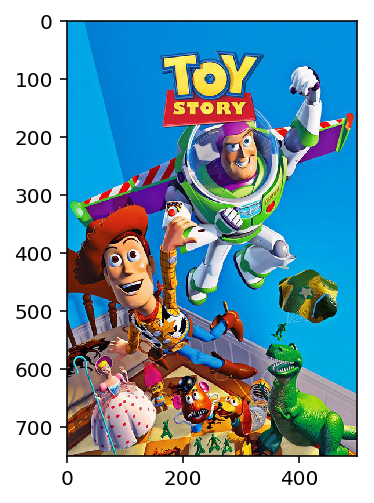

In [79]:
plt.imshow(plt.imread('data/movielens-100k/image/1.jpg'))

## Cora

In [ ]:
from graphsage.model import load_cora

In [ ]:
feat_data, labels, adj_lists = load_cora()
num_nodes, num_feats = feat_data.shape
num_classes = len(np.unique(labels))

num_nodes, num_feats, num_classes

In [ ]:
# Optional: Remove features and use identity matrix instead. 
# Set learning rate to 10 for this.
feat_data = np.eye(num_nodes)
num_feats = num_nodes

num_nodes, num_feats, num_classes

# GCN Layers

In [13]:
import random
import time
import math
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

In [14]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, in_features_func, adj_lists, num_sample=10, activation=F.relu):
        nn.Module.__init__(self)
        self.in_features = in_features
        self.out_features = out_features
        self.in_features_func = in_features_func
        self.adj_lists = adj_lists
        self.num_sample = num_sample
        self.activation = activation
        
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform(self.weight)
        
        
    def aggregate(self, nodes, adj_lists, include_self=False):
        """Return a vector for each node in `nodes` by mean-aggregating feature vectors from its neighborhood (or a sample thereof)."""
        sampled_neighbors_per_node = [adj_lists[node] for node in nodes]
        
        # TODO: Check if this improves the network
        #       Also, in graphsage, this is done after the sampling step (which doesn't make much sense though).
        if include_self:
            for sampled_neighbors, node in zip(sampled_neighbors_per_node, nodes):
                sampled_neighbors.add(node)
        
        if self.num_sample is not None:
            # TODO: See if local pointers bring speed improvements.
            for i in range(len(sampled_neighbors_per_node)):
                if self.num_sample <= len(sampled_neighbors_per_node[i]):
                    sampled_neighbors_per_node[i] = set(random.sample(sampled_neighbors_per_node[i], self.num_sample))
            
        # TODO: See if I can improve the code from here on.
        # TODO: Rename to unique_neighbors.
        unique_neighbors = list(set.union(*sampled_neighbors_per_node))
        unique_neighbors_to_index = {neighbor: i for i, neighbor in enumerate(unique_neighbors)}
        
        if unique_neighbors:

            # TODO: Check if this really needs to be a variable.
            # TODO: Maybe store mask in self and fill it with zeros here.
            mask = Variable(torch.zeros(len(nodes), len(unique_neighbors)), requires_grad=False)
            if self.is_cuda():
                mask = mask.cuda()
            # TODO: Understand and rename variables here.
            column_indices = [unique_neighbors_to_index[neighbor] for sampled_neighbors in sampled_neighbors_per_node for neighbor in sampled_neighbors]
            row_indices = [i for i in range(len(sampled_neighbors_per_node)) for j in range(len(sampled_neighbors_per_node[i]))]
            mask[row_indices, column_indices] = 1
            #plot_matrix(mask)

            num_neighbors = mask.sum(1, keepdim=True)
            mask /= num_neighbors + 1e-10  # prevent zero division

            #print(unique_neighbors)
            unique_neighbors_tensor = torch.LongTensor(unique_neighbors)
            if self.is_cuda():
                unique_neighbors_tensor = unique_neighbors_tensor.cuda()
            f = self.in_features_func(unique_neighbors_tensor)
            
            #print(len(nodes))
            #print(len(unique_neighbors_list))
            #print(mask.mm(f).shape)
            
            return mask.mm(f)
        else:
            # TODO: If there are no neighbors, this currently returns a zero vector. Is this correct?
            zeros = Variable(torch.zeros(len(nodes), self.in_features), requires_grad=False)
            if self.is_cuda():
                zeros = zeros.cuda()
            return zeros

        
    def forward(self, nodes):
        neighborhood_features = self.aggregate(nodes, self.adj_lists, include_self=True)
        
        # TODO: Maybe add features of nodes themselves,
        #       or include nodes themselves in sampling process in aggregate function (as in GraphSAGE,
        #       but collides with RGCN use of aggregate function).
        #node_features = self.in_features_func(torch.LongTensor(nodes))
        
        return self.activation(neighborhood_features.mm(self.weight.t()))
    
    def is_cuda(self):
        return self.weight.is_cuda

In [15]:
class RelationalGraphConvolution(GraphConvolution):
    def __init__(self, in_features, out_features, in_features_func, adj_lists_per_relation, 
                 num_sample=10, activation=F.relu):
        
        GraphConvolution.__init__(self, in_features, out_features, in_features_func, None, num_sample, activation)
        
        self.adj_lists_per_relation = adj_lists_per_relation
        
        self.num_relations = len(self.adj_lists_per_relation)
        self.weights_per_relation = nn.ParameterList()
        # TODO: adj_lists_per_relation is a dict {relation: adj_lists}, maybe change this to a list, so the 
        #       keys are always indices.
        for i_relation, relation in enumerate(self.adj_lists_per_relation):
            self.weights_per_relation.append(nn.Parameter(torch.FloatTensor(out_features, in_features)))
            nn.init.xavier_uniform(self.weights_per_relation[relation])
        
        
    def forward(self, nodes):
        # TODO: Make this more beautiful.
        if type(nodes) == torch.LongTensor or type(nodes) == torch.cuda.LongTensor:
            nodes_tensor = nodes
        else:
            nodes_tensor = torch.LongTensor(nodes)
            if self.is_cuda():
                nodes_tensor = nodes_tensor.cuda()
        node_features = self.in_features_func(nodes_tensor)
        
        summed_features = node_features.mm(self.weight.t())
        for i_relation, relation in enumerate(self.adj_lists_per_relation):
            neighborhood_features = self.aggregate(nodes, self.adj_lists_per_relation[relation], include_self=False)
            # TODO: Normalization constant. Currently is neighborhood size (see aggregate function).
            summed_features += neighborhood_features.mm(self.weights_per_relation[i_relation].t())

        return self.activation(summed_features)

# Supervised Classification (without relations and features)

In [16]:
class SupervisedGCN(nn.Module):

    def __init__(self, num_classes, feat_data, adj_lists):
        nn.Module.__init__(self)
        
        num_nodes, num_features = feat_data.shape
        
        features = nn.Embedding(num_nodes, num_features)
        features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
        
        self.graph_conv1 = GraphConvolution(num_features, 128, features, adj_lists, activation=F.relu)
        self.graph_conv2 = GraphConvolution(128, 128, self.graph_conv1, adj_lists, activation=F.relu)
        
        # TODO: Converges faster without bias. See if this holds for real data.
        self.dense = nn.Linear(128, num_classes, bias=False)
        nn.init.xavier_uniform(self.dense.weight)

    def forward(self, nodes):
        node_embeddings = self.graph_conv2(nodes)  # implicitly calls underlying conv layers
        scores = self.dense(node_embeddings)
        return scores

In [17]:
# Run algorithm.
np.random.seed(1)
random.seed(1)

use_cuda = True

net = SupervisedGCN(num_classes, feat_data, adj_lists)
if use_cuda and torch.cuda.is_available():
    print('Moving network to GPU.')
    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

times = []
for batch in range(100):
    #batch_nodes = Variable(torch.LongTensor(train[:256]), requires_grad=False)
    batch_nodes = train[:256]
    random.shuffle(train)
    
    start_time = time.time()
    
    optimizer.zero_grad()
    
    output = net(batch_nodes)
    target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
    if use_cuda and torch.cuda.is_available():
        target = target.cuda()
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    
    end_time = time.time()
    times.append(end_time-start_time)
    print(batch, loss.data[0])
    
    if batch % 10 == 0:
        val_output = net(val) 
        print("Validation Accuracy:", accuracy_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1)))
        print("Validation F1:", f1_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1), average="micro"))
        print("Average batch time:", np.mean(times))

Moving network to GPU.
0 0.692896485329
Validation Accuracy: 0.634
Validation F1: 0.634
Average batch time: 0.1904129981994629
1 0.667886972427
2 0.612422704697
3 0.529688358307
4 0.42939171195
5 0.319299668074
6 0.250481367111
7 0.250862538815
8 0.194756746292
9 0.183181121945
10 0.152682065964
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.06710889122702858
11 0.123559959233
12 0.0772185176611
13 0.0510042309761
14 0.0365696884692
15 0.0187319889665
16 0.0101769454777
17 0.00538808479905
18 0.00236057955772
19 0.000963839702308
20 0.000447682105005
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.06511790411812919
21 0.00017000362277
22 8.49878415465e-05
23 3.43294814229e-05
24 1.98967754841e-05
25 1.02631747723e-05
26 4.99188899994e-06
27 2.59838998318e-06
28 1.47707760334e-06
29 2.25566327572e-06
30 1.52364373207e-06
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.06462906252953314
31 4.22820448875e-07
32 1.02631747723e-06
33 6.

In [174]:
# Alternative version with epochs and progressbar.
# TODO: Update CUDA support.

from tqdm import tqdm

# Run algorithm.
np.random.seed(1)
random.seed(1)

net = SupervisedGCN(num_classes, feat_data, adj_lists)
#    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

num_epochs = 10
batch_size = 256

for epoch in range(1, num_epochs+1):
    
    
    #tqdm.write('Epoch {}/{}:'.format(epoch, num_epochs-1))

    random.shuffle(train)
    num_batches = int(len(train) / batch_size)
    
    with tqdm(total=num_batches, desc='Epoch {}/{}'.format(epoch, num_epochs), ncols=110) as pbar:

        for batch in range(num_batches):

            #print('\tBatch {}/{}:'.format(batch, num_batches-1), end=' ')

            from_node = batch * batch_size
            to_node = min((batch + 1) * batch_size, len(train))
            batch_nodes = train[from_node:to_node]

            optimizer.zero_grad()

            output = net(batch_nodes)
            target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()

            pbar.set_postfix(loss=loss.data[0])
            #print(loss.data[0])
            
            pbar.update()

        val_output = net(val) 
        val_acc = accuracy_score(labels[val], val_output.data.numpy().argmax(axis=1))
        val_f1 = f1_score(labels[val], val_output.data.numpy().argmax(axis=1), average="micro")
        pbar.set_postfix(loss=loss.data[0], val_acc=val_acc, val_f1=val_f1)


Epoch 10/10: 100%|██████████████████████████| 6/6 [00:01<00:00,  6.64it/s, loss=1.61e-13, val_acc=1, val_f1=1]


# Supervised Classification with relations

In [18]:
class SupervisedRGCN(nn.Module):

    def __init__(self, num_classes, feat_data, adj_lists_per_relation):
        nn.Module.__init__(self)
        
        num_nodes, num_features = feat_data.shape
        features = nn.Embedding(num_nodes, num_features)
        features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
        
        self.graph_conv1 = RelationalGraphConvolution(num_features, 128, features, adj_lists_per_relation)
        self.graph_conv2 = RelationalGraphConvolution(128, 128, self.graph_conv1, adj_lists_per_relation)
        
        # TODO: Converges faster without bias. See if this holds for real data.
        self.dense = nn.Linear(128, num_classes, bias=False)
        nn.init.xavier_uniform(self.dense.weight)

    def forward(self, nodes):
        node_embeddings = self.graph_conv2(nodes)  # implicitly calls underlying conv layers
        #print(node_embeddings.sum())
        scores = self.dense(node_embeddings)  # softmax is applied by CrossEntropyLoss
        return scores


In [19]:
# Run algorithm.
np.random.seed(1)
random.seed(1)

use_cuda = True

net = SupervisedRGCN(num_classes, feat_data, adj_lists_per_relation)
if use_cuda and torch.cuda.is_available():
    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])
print('Training on', len(train), 'nodes')

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

times = []
for batch in range(100):
    #batch_nodes = Variable(torch.LongTensor(train[:256]), requires_grad=False)
    
    random.shuffle(train)
    batch_nodes = train[:256]
    
    start_time = time.time()
    
    optimizer.zero_grad()
    
    output = net(batch_nodes)
    target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
    if use_cuda and torch.cuda.is_available():
        target = target.cuda()
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    
    end_time = time.time()
    times.append(end_time-start_time)
    print(batch, loss.data[0])
    
    if batch % 10 == 0:
        val_output = net(val) 
        print("Validation Accuracy:", accuracy_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1)))
        print("Validation F1:", f1_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1), average="micro"))
        print("Average batch time:", np.mean(times))

Training on 1625 nodes
0 0.690665960312
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.19429492950439453
1 0.56970000267
2 0.422767162323
3 0.333146989346
4 0.244888827205
5 0.187118723989
6 0.116868980229
7 0.0616429522634
8 0.031066134572
9 0.0174713600427
10 0.00768253672868
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.1721870248967951
11 0.00573282269761
12 0.00264684483409
13 0.00133715290576
14 0.00102490792051
15 0.00063599832356
16 0.000389914028347
17 0.000162918586284
18 0.000254969578236
19 0.000120875425637
20 8.7134540081e-06
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.16201589221046084
21 8.99191945791e-06
22 1.94106251001e-05
23 1.6987323761e-06
24 1.47707760334e-06
25 3.20374965668e-07
26 4.7042965889e-05
27 1.33737921715e-05
28 8.17980617285e-06
29 8.38190317154e-08
30 1.30385160446e-07
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.1524044159919985
31 2.64495611191e-07
32 1.63912773132e-0

# Link Prediction

In [20]:
class DistMultScorer(nn.Module):
    
    def __init__(self, entity_embedding_features, num_relations):
        nn.Module.__init__(self)
        self.relation_embedding = nn.Embedding(num_relations, entity_embedding_features)
        
    def init(self):
        nn.init.xavier_normal(self.relation_embedding.weight.data)

    def forward(self, subject_embeddings, object_embeddings, relations):
        # TODO: Give relations as tensor in the first place.
        relations_tensor = Variable(torch.LongTensor(relations), requires_grad=False)
        if self.relation_embedding.weight.is_cuda:
            relations_tensor = relations_tensor.cuda()
            
        relation_embeddings = self.relation_embedding(relations_tensor)
        scores = (subject_embeddings * relation_embeddings * object_embeddings).sum(1, keepdim=True)
        
        return scores

In [21]:
class UnsupervisedRGCN(nn.Module):

    def __init__(self, feat_data, adj_lists_per_relation, embedding_size=128, num_sample=10):
        nn.Module.__init__(self)
        
        num_nodes, num_features = feat_data.shape
        num_relations = len(adj_lists_per_relation)
        
        features = nn.Embedding(num_nodes, num_features)
        features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
        
        self.graph_conv1 = RelationalGraphConvolution(num_features, embedding_size, features, adj_lists_per_relation, activation=F.relu, num_sample=num_sample)
        self.graph_conv2 = RelationalGraphConvolution(embedding_size, embedding_size, self.graph_conv1, adj_lists_per_relation, activation=F.relu, num_sample=num_sample)
        
        self.dist_mult = DistMultScorer(embedding_size, num_relations)
        
    def forward(self, triples):
        # TODO: This computes lots of duplicates if nodes appear in multiple triples or as subject and object.
        #       See if this can be improved by finding the unique nodes, running graph_conv2 on them once,
        #       and then merging this back. Could also be applied in GraphConvolution (in addition to here, 
        #       because GraphConvolution cannot consider duplicates in subject and object).
        #unique_nodes = set.union(set(triples[:, 0]), set(triples[:, 1]))
        #unique_nodes_to_index = {node: i for i, node in enumerate(unique_nodes)}
        
        #unique_nodes_features = self.graph_conv2(unique_nodes)
        #print(unique_nodes_features)
        
        from_node_embeddings = self.graph_conv2(triples[:, 0])  # implicitly calls underlying conv layers
        to_node_embeddings = self.graph_conv2(triples[:, 1])  # implicitly calls underlying conv layers
        
        scores = self.dist_mult(from_node_embeddings, to_node_embeddings, triples[:, 2])
        return scores

In [22]:
# Training utils for link prediction.

def sample_negatives(triples, num_nodes, num_negatives=1):
    """Return a copy of triples where either the subject or the object in each triple is replaced with a random entity."""
    corrupted_triples = []
    for i in range(num_negatives):
        for s, o, r in triples:
            if np.random.rand() < 0.5:
                corrupted_triples.append((np.random.randint(num_nodes), o, r))
            else:
                corrupted_triples.append((s, np.random.randint(num_nodes), r))
    return corrupted_triples


class SimplifiedMarginRankingLoss(nn.MarginRankingLoss):
    """Same as torch.nn.MarginRankingLoss, but input1 is always higher than input2."""
    
    def __call__(self, input1, input2):
        target = Variable(torch.ones(input1.shape), requires_grad=False)
        if input1.is_cuda:
            target = target.cuda()
        return super(SimplifiedMarginRankingLoss, self).__call__(input1, input2, target)
       
        

In [ ]:
# Ranking evaluation.

def in2d(ar1, ar2):
    """
    Return indices of rows of `ar1` that are equal to one of the rows in `ar2`.
    
    Inspired by: https://stackoverflow.com/questions/8317022/get-intersecting-rows-across-two-2d-numpy-arrays
    """
    nrows, ncols = ar1.shape
    dtype={'names': ['f{}'.format(i) for i in range(ncols)],
           'formats': ncols * [ar1.dtype]}

    return np.in1d(ar1.view(dtype), ar2.view(dtype))

        
class RankingEvaluation(object):
    
    def __init__(self, triples, num_nodes, filtered=False, show_progress=False):
        self.triples = triples
        self.num_nodes = num_nodes
        self.filtered = filtered
        
        
        if self.filtered:
            
            self.true_triples_subject_corrupted_per_triple = []
            self.true_triples_object_corrupted_per_triple = []
        
            # TODO: Refactor.
            for triple in tqdm_notebook(self.triples) if show_progress else self.triples:
                triples_subject_corrupted = np.zeros((self.num_nodes, 3), dtype=int)
                triples_subject_corrupted[:, 0] = np.arange(num_nodes)
                triples_subject_corrupted[:, 1] = triple[1]
                triples_subject_corrupted[:, 2] = triple[2]
                # TODO: Store these as indices or boolean arrays? Check what is faster overall.
                self.true_triples_subject_corrupted_per_triple.append(np.where(in2d(triples_subject_corrupted, triples_arr))[0])
                
                triples_object_corrupted = np.zeros((self.num_nodes, 3), dtype=int)
                triples_object_corrupted[:, 0] = triple[0]
                triples_object_corrupted[:, 1] = np.arange(num_nodes)
                triples_object_corrupted[:, 2] = triple[2]
                self.true_triples_object_corrupted_per_triple.append(np.where(in2d(triples_object_corrupted, triples_arr))[0])
                
                
    def _get_rank(self, scoring_model, subject_embeddings, object_embeddings, relations, n, true_triples=None):
        scores = scoring_model(subject_embeddings, object_embeddings, relations).cpu().data.numpy()
        score_true_triple = scores[n]
        
        if self.filtered:
            scores_corrupted_triples = np.delete(scores, true_triples)
            #print('Removed', len(scores) - len(scores_corrupted_triples), 'triples')
        else:
            scores_corrupted_triples = np.delete(scores, [n])
            
        rank = sp.stats.rankdata(-np.hstack([score_true_triple, scores_corrupted_triples]), 'ordinal')[0]  # apply negative so highest score is 
        
        #rank_unfiltered = sp.stats.rankdata(-scores, 'ordinal')[n]
        #print(rank, rank_unfiltered, '--> changed', rank_unfiltered-rank, 'ranks')
        
        return rank
    
    
    def __call__(self, embedding_model, scoring_model, verbose=False, show_progress=False):
        
        all_node_embeddings = embedding_model(np.arange(self.num_nodes))
        ranks = []

        for i, triple in enumerate(tqdm_notebook(self.triples)) if show_progress else enumerate(self.triples):
            #print(triple, ':', end=' ')

            repeated_subject_embedding = all_node_embeddings[triple[0]].expand(self.num_nodes, -1)
            repeated_object_embedding = all_node_embeddings[triple[1]].expand(self.num_nodes, -1)
            repeated_relation = np.repeat(triple[2], self.num_nodes)

            # TODO: Refactor this.
            rank_subject_corrupted = self._get_rank(scoring_model, all_node_embeddings, repeated_object_embedding, repeated_relation, triple[0], self.true_triples_subject_corrupted_per_triple[i] if self.filtered else None)
            ranks.append(rank_subject_corrupted)
            
            rank_object_corrupted = self._get_rank(scoring_model, repeated_subject_embedding, all_node_embeddings, repeated_relation, triple[1], self.true_triples_object_corrupted_per_triple[i] if self.filtered else None)
            ranks.append(rank_object_corrupted)
            
            # TODO: Check if these are more or less the same.
            if verbose: print(rank_subject_corrupted, rank_object_corrupted)
            
        ranks = np.asarray(ranks)
        
        def hits_at(n):
            return np.sum(ranks <= n) / len(ranks)

        return np.mean(ranks), np.mean(1 / ranks), hits_at(1), hits_at(3), hits_at(10)

In [23]:
# Set up dataset splits and ranking evaluation. 

# TODO: Use a bigger test and validation set here (we are training on 100k triples!).
train_val, test = train_test_split(triples_arr, test_size=1000, random_state=0)
train, val = train_test_split(train_val, test_size=1000, random_state=0)

# TODO: There's some bug with in2d now, that wasn't here before refactoring.
train_ranker = RankingEvaluation(train[:1000], num_nodes, filtered=False, show_progress=True)
val_ranker = RankingEvaluation(val, num_nodes, filtered=False, show_progress=True)

In [24]:
# Set up network, loss, optimizer and history logger. Start a new training run from here.
use_cuda = True

# TODO: Maybe store relation weight parameters in a 3D tensor.
net = UnsupervisedRGCN(feat_data, adj_lists_per_relation, 256, 10)
if use_cuda and torch.cuda.is_available():
    print('Moving network to GPU')
    net.cuda()
    
# TODO: Maybe move loss function to model.
loss_function = SimplifiedMarginRankingLoss(1)
parameters_to_optimize = filter(lambda parameter: parameter.requires_grad, net.parameters())
optimizer = torch.optim.Adam(parameters_to_optimize, lr=0.001)
print('Optimizing', len(parameters_to_optimize), 'parameters')

history = utils.History()

Moving network to GPU
Optimizing 13 parameters


In [ ]:
# Training loop. Run this again to continue training on the same network. 

np.random.seed(1)
random.seed(1)

# TODO: Implement training via classification of correct/corrupted triples.

num_epochs = 30
batch_size = 128
num_batches = int(len(train) / batch_size)+1

for epoch in range(num_epochs):
    
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    
    # num_negatives = 2
    # train_and_negatives = np.hstack([train, sample_negatives(train, num_nodes, num_negatives)])
    # print(train_and_negatives.shape)
    # y = Variable(torch.zeros(len(train_and_negatives), 1), requires_grad=False)
    # y[:len(train), 0] = 1
    # if use_cuda and torch.cuda.is_available():
    #     y = y.cuda()
    # TODO: Wrap train_and_negatives and y in list of tuples or make split_into_batches accept multiple arrays.
    # batches = tqdm_notebook(split_into_batches(train_and_negatives, batch_size, shuffle=True))

    #train = np.random.permutation(train)
    batches = tqdm_notebook(utils.split_into_batches(train, batch_size=batch_size, shuffle=True), total=num_batches)
    batches_history = utils.History()
    
    for batch, batch_triples in enumerate(batches):
        
        #print(batch, batch_triples.shape)

        optimizer.zero_grad()
        output = net(np.asarray(batch_triples))
        output_negative = net(np.asarray(sample_negatives(batch_triples, num_nodes)))

        loss = loss_function(output, output_negative)
        # loss = loss_function(output, y)
        loss.backward()
        optimizer.step()

        batches_history.log_metric('loss', loss.data[0])
        batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
        batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
        batches_history.log_metric('median_diff', (output - output_negative).median().data[0])

        batches.set_postfix(batches_history.latest())
            

    val_output = net(np.asarray(val))
    val_output_negative = net(np.asarray(sample_negatives(val, num_nodes)))
    
    history.log_metric('loss', batches_history.mean('loss'), 
                       loss_function(val_output, val_output_negative).data[0], 'Loss', print_=True)
    history.log_metric('acc', batches_history.mean('acc'), 
                       (val_output > val_output_negative).float().mean().data[0], 'Accuracy', print_=True)
    history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
                       (val_output - val_output_negative).mean().data[0], 'Mean Difference', print_=True)
    history.log_metric('median_diff', batches_history.mean('median_diff'), 
                       (val_output - val_output_negative).median().data[0], 'Median Difference', print_=True)
    

    print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
    print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
    mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(net.graph_conv2, net.dist_mult)
    val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(net.graph_conv2, net.dist_mult)
    history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
    history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
    history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
    history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
    history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)
    
    print('-'*80)
    print()

Epoch 1/30


HBox(children=(IntProgress(value=0, max=766), HTML(value=u'')))


Loss:       0.3145649573
Val Loss:   0.254291325808

Accuracy:       0.865802464068
Val Accuracy:   0.893000006676

Mean Difference:       4.10065792494
Val Mean Difference:   4.88130903244

Median Difference:       2.17070265747
Val Median Difference:   2.6284327507

Running rank evaluation for train in raw setting...
Running rank evaluation for val in raw setting...
Mean Rank:       272.156
Val Mean Rank:   284.866

Mean Rec Rank:       0.0234358152094
Val Mean Rec Rank:   0.0264546975678

Hits@1:       0.004
Val Hits@1:   0.0075

Hits@3:       0.0165
Val Hits@3:   0.017

Hits@10:       0.0455
Val Hits@10:   0.0475

--------------------------------------------------------------------------------

Epoch 2/30


HBox(children=(IntProgress(value=0, max=766), HTML(value=u'')))

In [ ]:
# Changes vs 3: Decreased batch size to 128, raw ranking evaluation (because of unresolved bug in filtered setting due to refactoring), refactoring (shouldn't affect training, only moved code to utils and deleted old code).

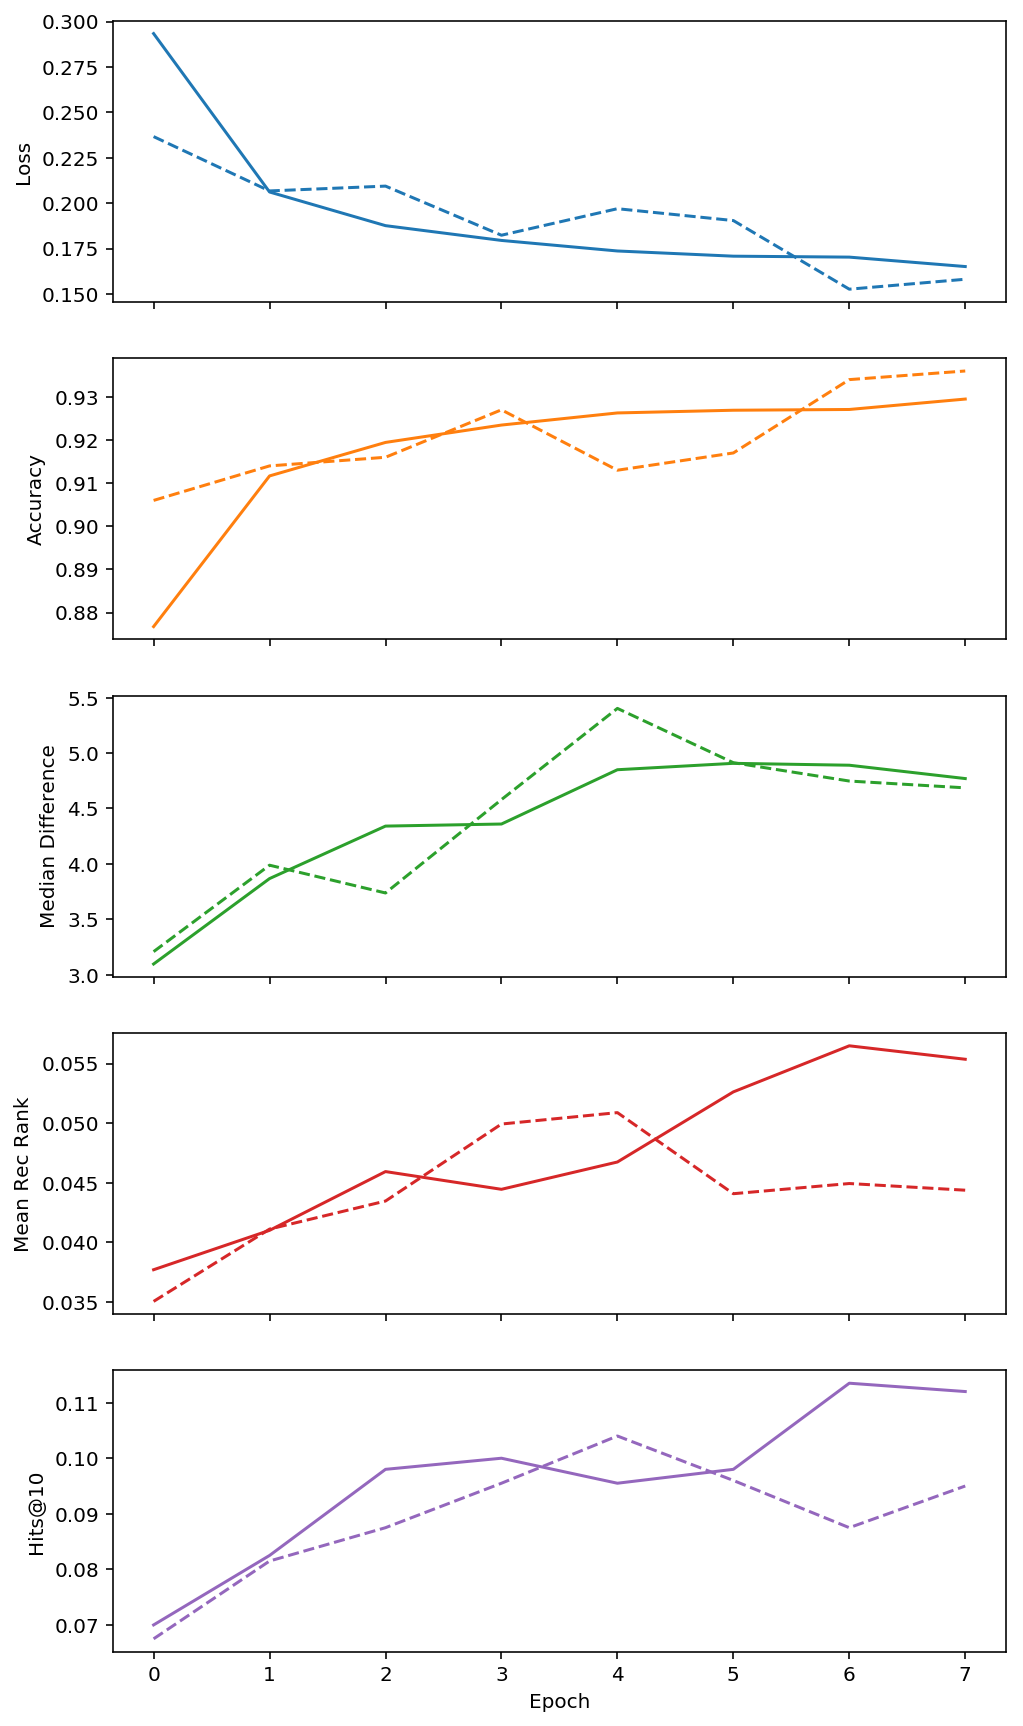

In [480]:
to_plot = ['loss', 'acc', 'median_diff', 'mean_rec_rank', 'hits_10']
figsize = (8, 15)

# TODO: Implement function to compare history objects in a plot.
history.plot(*to_plot, figsize=figsize)

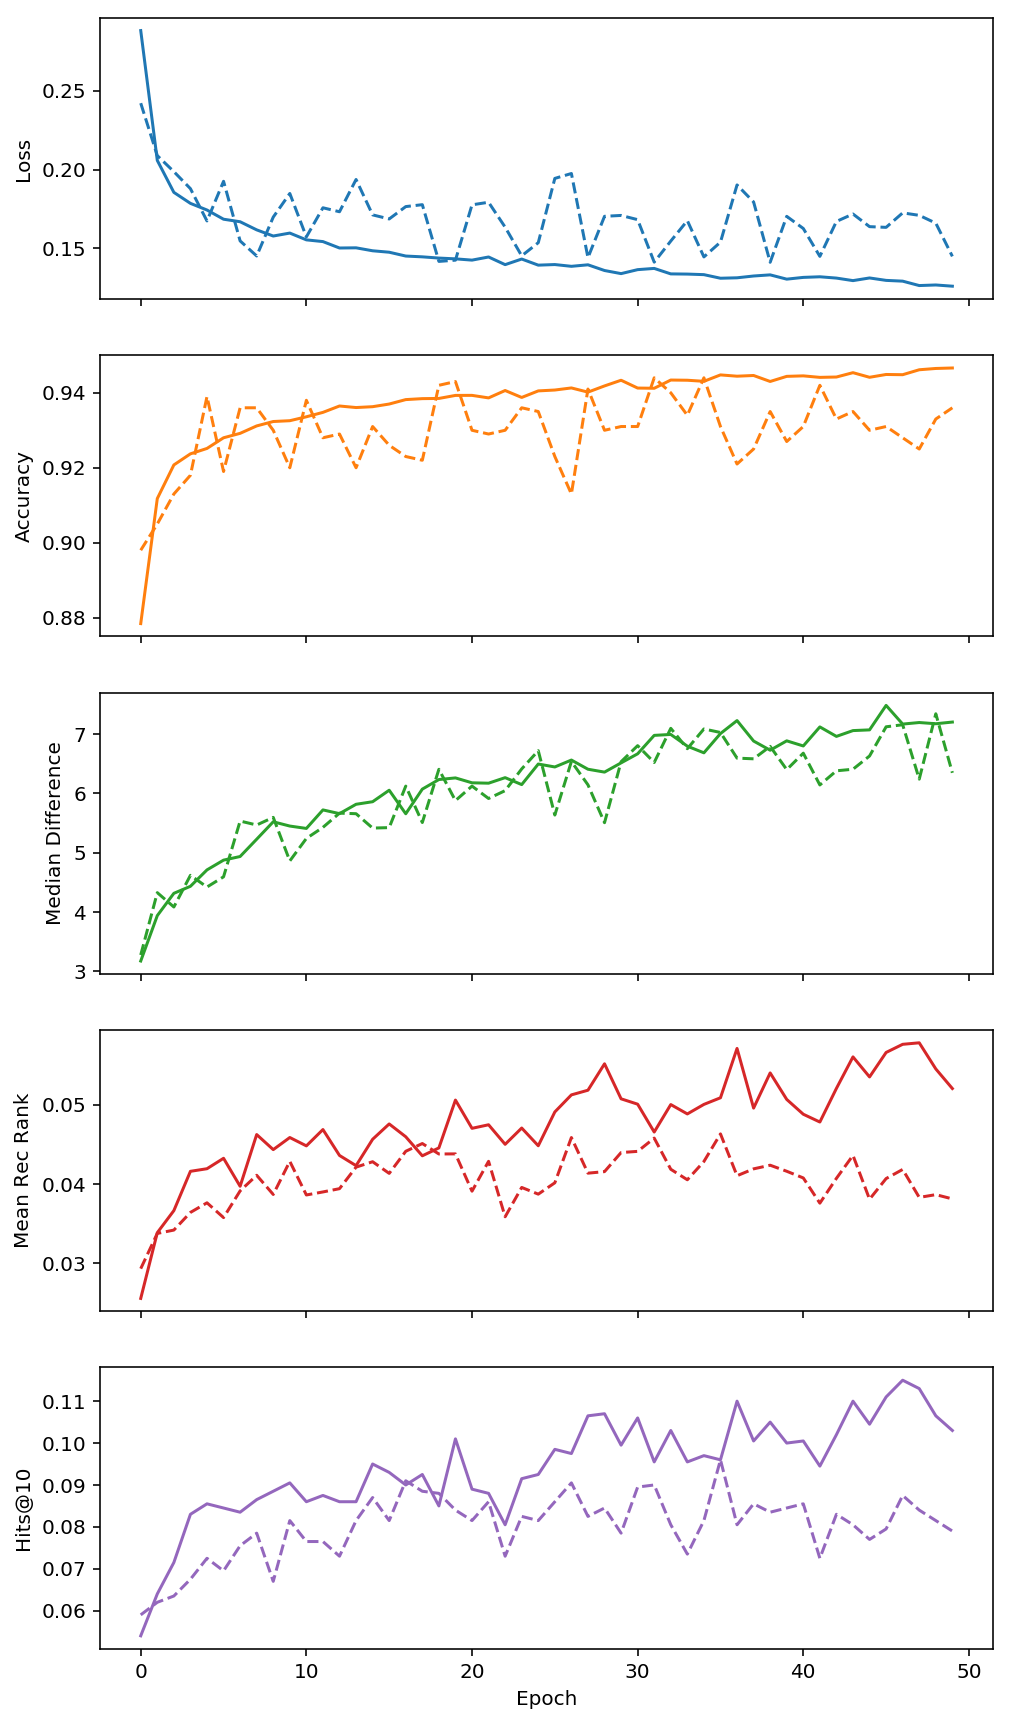

In [153]:
utils.History.load('logs/1_link-prediction-movielens-baseline.tsv').plot(*to_plot, figsize=figsize)

In [482]:
#history.save('logs/4_fb15k-237.tsv')

In [483]:
!ls logs

1_link-prediction-movielens-baseline.tsv  3_directed-edges-in-adj-lists.tsv
2_filtered-ranking-evaluation.tsv
